In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import pandas as pd 

from forward_step import ComputeLoss
from train import TrainerDAGMM
from model import DAGMM
from data_loader import correct,incorrect

In [2]:
class Args:
    num_epochs = 200
    patience = 50
    lr = 1e-4
    lr_milestones = [50]
    latent_dim = 2
    n_gmm = 6
    lambda_energy = 0.1
    lambda_cov = 0.005

In [3]:
args = Args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = torch.tensor(correct()).float()
Y = torch.tensor(incorrect()).float()
print(X.shape)
print(Y.shape)

torch.Size([90, 240, 117])
torch.Size([90, 240, 117])


In [4]:
# convert data to two dimensions
X_NN = X.reshape((-1,117))
Y_NN = Y.reshape((-1,117))
print(X_NN.shape)
print(Y_NN.shape)

torch.Size([21600, 117])
torch.Size([21600, 117])


In [5]:
dagmm = TrainerDAGMM(args, X_NN, device)
dagmm.train()

Training DAGMM... Epoch: 0, Loss: 3234.458
Training DAGMM... Epoch: 1, Loss: 3234.458
Training DAGMM... Epoch: 2, Loss: 3234.457
Training DAGMM... Epoch: 3, Loss: 3234.458
Training DAGMM... Epoch: 4, Loss: 3234.457
Training DAGMM... Epoch: 5, Loss: 3234.457
Training DAGMM... Epoch: 6, Loss: 3234.459
Training DAGMM... Epoch: 7, Loss: 3234.455
Training DAGMM... Epoch: 8, Loss: 3234.458
Training DAGMM... Epoch: 9, Loss: 3234.457
Training DAGMM... Epoch: 10, Loss: 3234.459
Training DAGMM... Epoch: 11, Loss: 3234.455
Training DAGMM... Epoch: 12, Loss: 3234.457
Training DAGMM... Epoch: 13, Loss: 3234.454
Training DAGMM... Epoch: 14, Loss: 3234.457
Training DAGMM... Epoch: 15, Loss: 3234.459
Training DAGMM... Epoch: 16, Loss: 3234.456
Training DAGMM... Epoch: 17, Loss: 3234.457
Training DAGMM... Epoch: 18, Loss: 3234.457
Training DAGMM... Epoch: 19, Loss: 3234.458
Training DAGMM... Epoch: 20, Loss: 3234.458
Training DAGMM... Epoch: 21, Loss: 3234.459
Training DAGMM... Epoch: 22, Loss: 3234.45

In [6]:
z_xc,x_hat,z_x,gamma = dagmm.model(X_NN)
print(z_xc.shape)
print(x_hat.shape)
print(z_x.shape)
print(gamma.shape)

torch.Size([21600, 2])
torch.Size([21600, 117])
torch.Size([21600, 4])
torch.Size([21600, 6])


In [7]:
compute = ComputeLoss(dagmm.model, None, None, device, Args.n_gmm)
phi, mu, cov = compute.compute_params(z_x, gamma)

In [8]:
# energy is the average of negative likelihood over samples
E_z, cov_diag= compute.compute_energy(z_x, gamma,phi,mu,cov)
E_z

tensor(-4.5094, grad_fn=<MeanBackward0>)

In [9]:
# prepare reduced data
R = 90
Z_X = z_x.reshape((R,240,4))
z_yc,y_hat,z_y,_ = dagmm.model(Y_NN)
Z_Y = z_y.reshape((R,240,4))

In [10]:
# compute likelihood for correct and incorrect motions
lik = {"corr":[],"incorr":[]}
for r in range(R):
    cl,_ = compute.compute_energy(Z_X[r], gamma,phi,mu,cov)
    lik["corr"].append(-cl.detach())
    il,_ = compute.compute_energy(Z_Y[r], gamma,phi,mu,cov)
    lik["incorr"].append(-il.detach())

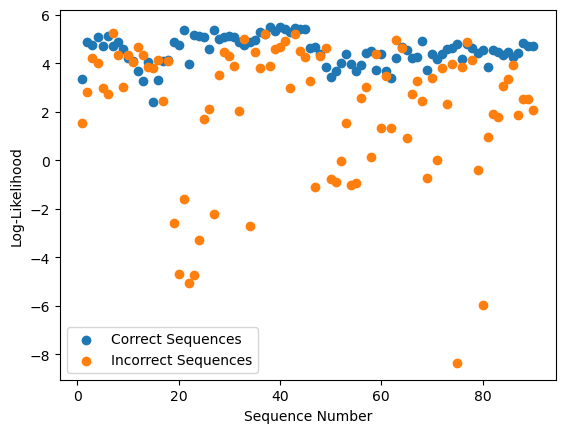

In [11]:
plt.scatter(np.arange(1,91),lik["corr"], label = "Correct Sequences")
plt.scatter(np.arange(1,91),lik["incorr"], label = "Incorrect Sequences")
plt.xlabel("Sequence Number")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.show()